In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import sys
sys.path.append('/Users/ivan_zorin/Documents/DEV/code/ntl/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


from ntl.data import get_dataset, get_sgcc_data

import darts

from darts import models
from darts import metrics
from darts import TimeSeries
# from darts.timeseries import TimeSeries


from darts.models import ExponentialSmoothing
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts.dataprocessing import Pipeline
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.timeseries_generation import linear_timeseries
from darts.datasets import MonthlyMilkDataset, MonthlyMilkIncompleteDataset

from darts.ad.scorers.difference_scorer import DifferenceScorer
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller

In [7]:
data_path = '/Users/ivan_zorin/Documents/DEV/data/sgcc/data.csv'
norm, anomal = get_sgcc_data(data_path, normal_anomal_split=True)

In [8]:
norm_ts = TimeSeries.from_group_dataframe(norm, group_cols='CONS_NO', time_col='date', value_cols='cons', freq='d')
# anomal_ts = TimeSeries.from_group_dataframe(anomal, group_cols='CONS_NO', time_col='date', value_cols='cons', freq='d')


<Axes: xlabel='date'>

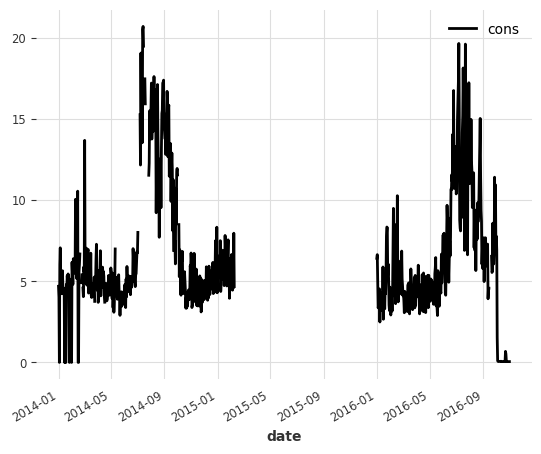

In [9]:
norm_ts[3].plot()

In [10]:
scaler = Scaler(verbose=True, n_jobs=-1)
norm_scaled = scaler.fit_transform(norm_ts)

Fitting (Scaler):   0%|          | 0/38757 [00:00<?, ?it/s]

/Users/ivan_zorin/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/ivan_zorin/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/Users/ivan_zorin/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/ivan_zorin/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


Transform (Scaler):   0%|          | 0/38757 [00:00<?, ?it/s]

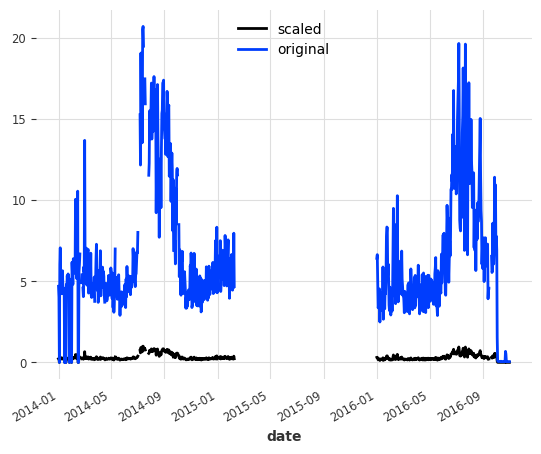

In [11]:
idx = 3
for t, label in zip([norm_scaled[idx], norm_ts[idx]], ['scaled', 'original']):
    t.plot(label=label)
    

In [13]:
filler = MissingValuesFiller(fill='auto', n_jobs=-1)

In [14]:
norm_ts_filled = filler.transform(norm_scaled, method='linear')
# anomal_ts_filled = filler.transform(anomal_ts, method='linear')


<Axes: xlabel='date'>

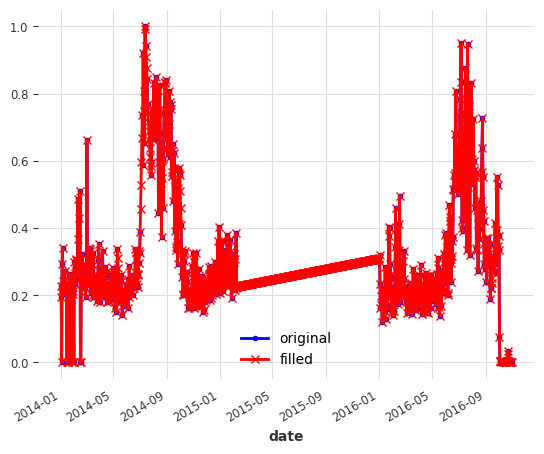

In [15]:
idx = 3
norm_scaled[idx].plot(label='original', color='blue', alpha=1, marker='.')
norm_ts_filled[idx].plot(marker='x', color='red', label='filled', alpha=1)

In [17]:
train, test = norm_ts_filled[idx].split_before(0.75)

<Axes: xlabel='date'>

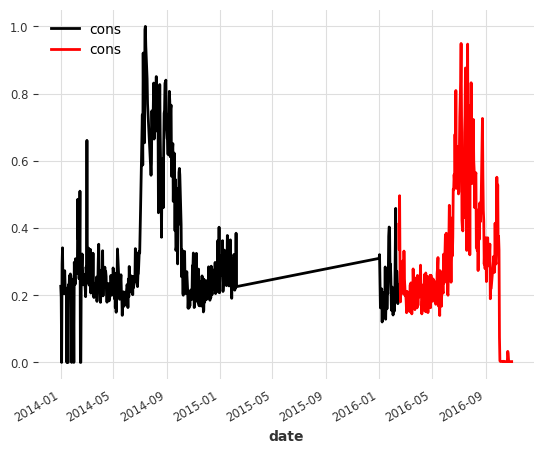

In [19]:
train.plot()
test.plot(color='red')

In [31]:
for m in range(2, 20):
    res = check_seasonality(norm_ts_filled[idx], m=m)
    print(m, res)

2 (False, 0)
3 (False, 0)
4 (False, 0)
5 (False, 0)
6 (False, 0)
7 (False, 0)
8 (False, 0)
9 (False, 0)
10 (False, 0)
11 (False, 0)
12 (False, 0)
13 (False, 0)
14 (False, 0)
15 (False, 0)
16 (False, 0)
17 (False, 0)
18 (False, 0)
19 (False, 0)


In [32]:
sample = norm_ts_filled[idx]

In [62]:
def sample_model(data, model, metric, **model_kwargs):
    metrics = []
    for ts in tqdm(data):
        train, test = ts.split_before(0.8)
        model.fit(train, **model_kwargs)
        y_hat = model.predict(len(test))
        metrics.append(metric(y_hat, test))
        
    return metrics
        

<TimeSeries (DataArray) (date: 208, component: 1, sample: 1)>
array([[[0.20241546]],

       [[0.14444444]],

       [[0.1821256 ]],

       [[0.19227053]],

       [[0.23091787]],

       [[0.18888889]],

       [[0.18937198]],

       [[0.26135266]],

       [[0.152657  ]],

       [[0.18405797]],

...

       [[0.03285024]],

       [[0.02512077]],

       [[0.00289855]],

       [[0.00241546]],

       [[0.00241546]],

       [[0.00241546]],

       [[0.00241546]],

       [[0.00241546]],

       [[0.00241546]],

       [[0.00241546]]])
Coordinates:
  * date       (date) datetime64[ns] 2016-04-07 2016-04-08 ... 2016-10-31
  * component  (component) object 'cons'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates                           CONS_NO\n...
    hierarchy:          None

In [70]:
naive_seasonal = sample_model(norm_scaled, models.NaiveSeasonal(K=7), metrics.mae)

  0%|          | 0/38757 [00:00<?, ?it/s]

/Users/ivan_zorin/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivan_zorin/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ivan_zorin/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivan_zorin/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/ivan_zorin/opt/miniconda3/envs/pytorch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivan_zorin/op

(array([1.4334e+04, 1.6576e+04, 5.8710e+03, 1.2610e+03, 3.4000e+02,
        1.0500e+02, 4.2000e+01, 8.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([0.      , 0.095478, 0.190956, 0.286434, 0.381912, 0.47739 ,
        0.572868, 0.668346, 0.763824, 0.859302, 0.95478 ]),
 <BarContainer object of 10 artists>)

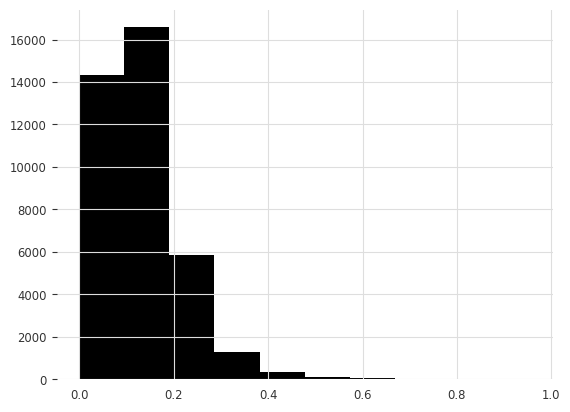

In [71]:
plt.hist(naive_seasonal)

In [ ]:
chech_models = [
    models.NaiveMovingAverage()
]

1107.7729566320518

<Axes: xlabel='date'>

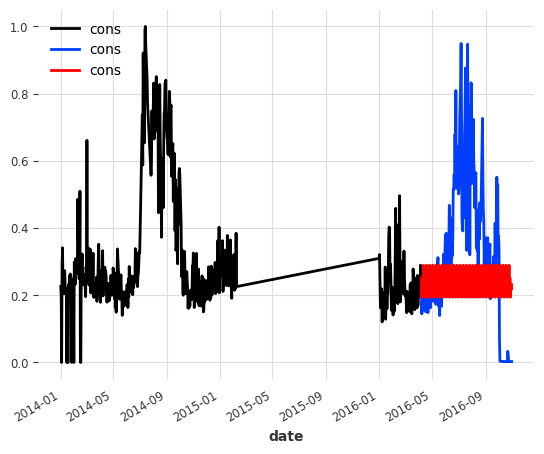